In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pycocotools.coco import COCO
import cv2




In [2]:
annotation_file = 'labelme2coco.json'
coco = COCO(annotation_file)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


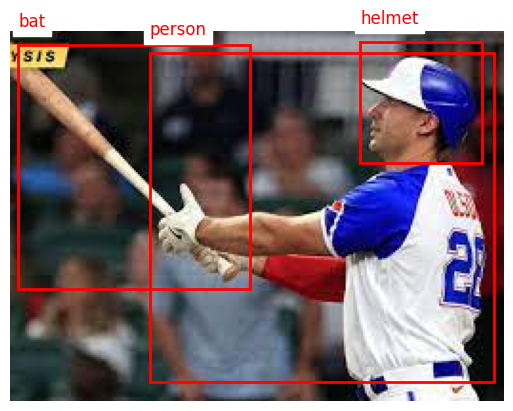

In [3]:
import os
from glob import glob
import json

# coco 경로
annotations_file = 'labelme2coco.json'

# 이미지 경로를 가져옵니다.
image_files = glob('data/baseball_hitter/*.jpg')
if not image_files:
    raise FileNotFoundError("No images found in the specified directory.")

# 첫 번째 이미지를 사용합니다.
image_path = image_files[42]

# 이미지 파일 이름에서 숫자로 된 ID를 추출하는 대신 COCO JSON에서 이미지 메타데이터를 찾습니다.
image_filename = os.path.basename(image_path)

#json file 로드
with open(annotations_file, 'r') as f:
    coco_data = json.load(f)

# 이미지 찾기
image_data = None
for img in coco_data['images']:
    if img['file_name'] == image_filename:
        image_data = img
        break

if image_data is None:
    raise ValueError(f"No matching image found in COCO dataset for file name: {image_filename}")

image_id = image_data['id']

# 이미지를 로드합니다.
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 이미지 출력
plt.imshow(img)
plt.axis('off')

# 이미지에 해당하는 주석 ID를 가져옵니다.
annotation_ids = [ann['id'] for ann in coco_data['annotations'] if ann['image_id'] == image_id]
annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]
# 주석 시각화
ax = plt.gca()
for annotation in annotations:
    bbox = annotation['bbox']
    rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    category = coco.loadCats(annotation['category_id'])[0]['name']
    plt.text(bbox[0], bbox[1] - 10, category, color='r', fontsize=12, backgroundcolor='w')

plt.show()

In [4]:
import os
import json
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms as T
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as transforms
from typing import Callable, Optional, Sequence, Tuple
from torch import Tensor
import random


In [5]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, annotations_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.coco = COCO(annotations_file)
        self.image_ids = list(sorted(self.coco.imgs.keys()))

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image_info = self.coco.loadImgs(image_id)[0]
        image = Image.open(os.path.join(self.root_dir, image_info['file_name'])).convert('RGB')
        
        annotations = self.coco.loadAnns(self.coco.getAnnIds(imgIds=image_id))
        boxes = []
        labels = []
        for annotation in annotations:
            bbox = annotation['bbox']
            boxes.append(bbox)
            labels.append(annotation['category_id'] - 1)
        
        boxes = np.array(boxes)
    
        # 박스의 길이를 위치로 변환
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]     # boxes[, 0]은 박스의 x 시작위치, boxes[, 2]은 박스의 x 길이
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]     # boxes[, 1]은 박스의 y 시작위치, boxes[, 3]은 박스의 y 길이

        
        if self.transform is not None:
            image = self.transform(image)
            orig_w, orig_h = image_info['width'], image_info['height']
            w_ratio, h_ratio = 256 / orig_w, 256 / orig_h
            boxes[:, 0] *= w_ratio
            boxes[:, 1] *= h_ratio
            boxes[:, 2] *= w_ratio
            boxes[:, 3] *= h_ratio
        
        target = {
            'image': torch.as_tensor(image, dtype=torch.float32),
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'labels': torch.as_tensor(labels, dtype=torch.int64)
        }
        
        return image, target, image_id

def collate_fn(batch: Tensor) -> Tuple:
    return tuple(zip(*batch))

In [6]:
# 데이터셋 및 전처리 정의
root_dir = 'data/baseball_hitter/'
annotations_file = 'labelme2coco.json'

dataset = CustomDataset(
    root_dir=root_dir,
    annotations_file=annotations_file,
    transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((256, 256)),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
)

# 전체 데이터셋의 인덱스 리스트 생성
indices = list(range(len(dataset)))

# 80% 학습, 20% 나머지로 분할
train_indices, rest_indices = train_test_split(indices, test_size=0.2, random_state=42)

# 나머지 20%를 10% 검증, 10% 테스트로 분할
val_indices, test_indices = train_test_split(rest_indices, test_size=0.5, random_state=42)

# Subset 객체를 사용하여 각 데이터셋 생성
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)




# DataLoader 정의
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=0, collate_fn=collate_fn)






# DataLoader 길이 출력
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
45
6
6


In [7]:
# 사전 훈련된 Faster R-CNN 모델 로드
model = fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 3
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


/home/jongsu/anaconda3/envs/detection/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jongsu/anaconda3/envs/detection/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# IoU 계산 함수 정의 (bounding boxes 용)
def calculate_iou(box1, box2):
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    inter_area = max(inter_x_max - inter_x_min, 0) * max(inter_y_max - inter_y_min, 0)
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)
    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area
    return iou

def calculate_mean_iou(outputs, targets):
    ious = []
    for output, target in zip(outputs, targets):
        pred_boxes = output['boxes']
        true_boxes = target['boxes']
        for pb, tb in zip(pred_boxes, true_boxes):
            iou = calculate_iou(pb, tb)
            ious.append(iou)
    return np.mean(ious)


In [9]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 5

def train_step(images, targets, training=True):
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    if training:
        model.train()
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        return losses.item()
    else:
        model.eval()
        with torch.no_grad():
            outputs = model(images)
            return outputs

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_iou = 0
    for images, targets, image_ids in train_loader:
        loss = train_step(images, targets, training=True)
        train_loss += loss
        
        outputs = train_step(images, targets, training=False)
        outputs = [{k: v.cpu().numpy() for k, v in t.items()} for t in outputs]
        targets_np = [{k: v.cpu().numpy() for k, v in t.items()} for t in targets]
        
        iou = calculate_mean_iou(outputs, targets_np)
        train_iou += iou

    lr_scheduler.step()

    model.eval()
    val_iou = 0
    with torch.no_grad():
        for images, targets, image_ids in val_loader:
            outputs = train_step(images, targets, training=False)
            outputs = [{k: v.cpu().numpy() for k, v in t.items()} for t in outputs]
            targets_np = [{k: v.cpu().numpy() for k, v in t.items()} for t in targets]
            
            iou = calculate_mean_iou(outputs, targets_np)
            val_iou += iou

    print(f"Epoch: {epoch}, Training Loss: {train_loss/len(train_loader)}, Training IoU: {train_iou/len(train_loader)}, Validation IoU: {val_iou/len(val_loader)}")

    
model.eval()
test_iou = 0
with torch.no_grad():
    for images, targets, image_ids in test_loader:
        outputs = train_step(images, targets, training=False)
        outputs = [{k: v.cpu().numpy() for k, v in t.items()} for t in outputs]
        targets_np = [{k: v.cpu().numpy() for k, v in t.items()} for t in targets]
        
        iou = calculate_mean_iou(outputs, targets_np)
        test_iou += iou
        
print(f"Test evaluation complete. Test IoU: {test_iou/len(test_loader)}")


Epoch: 0, Training Loss: 0.47469629247983297, Training IoU: 0.12692285340441953, Validation IoU: 0.18888950982086714
Epoch: 1, Training Loss: 0.3750692360930973, Training IoU: 0.22085812914086667, Validation IoU: 0.2903619344967107
Epoch: 2, Training Loss: 0.32171614997916753, Training IoU: 0.33215581810466965, Validation IoU: 0.37060805748675074
Epoch: 3, Training Loss: 0.24620424343480005, Training IoU: 0.3591470009028122, Validation IoU: 0.30830674180169665
Epoch: 4, Training Loss: 0.22682625734143788, Training IoU: 0.3828115519475525, Validation IoU: 0.34215752458170295
Test evaluation complete. Test IoU: 0.22685870982014522


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


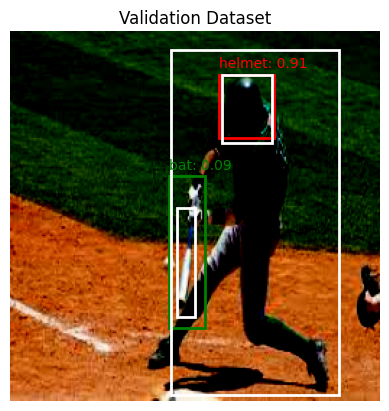

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


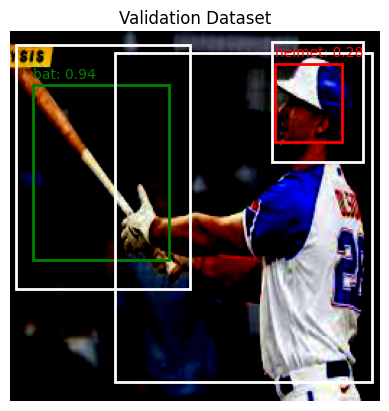

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


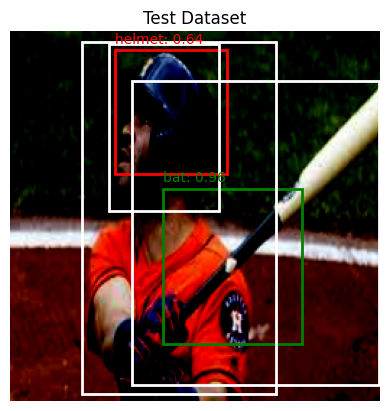

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


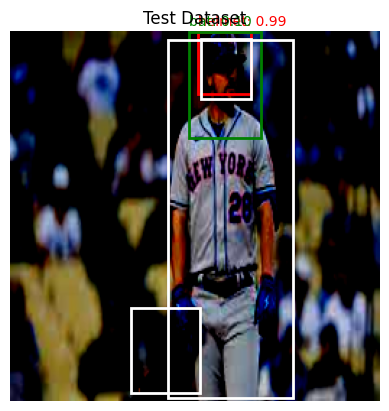

In [12]:
def visualize_predictions(images, outputs, targets, dataset_name):
    """
    이미지, 예측된 출력(output), 실제 타겟(targets)을 받아 시각화하는 함수.

    Args:
    - images (list of torch.Tensor): 시각화할 이미지들의 리스트
    - outputs (list of dict): 예측된 출력 정보들의 리스트
    - targets (list of dict): 실제 타겟 정보들의 리스트
    - dataset_name (str): 이미지가 속한 데이터셋의 이름 (예: 'Validation', 'Test')
    """
    class_names = ['helmet', 'bat', 'person']  # 클래스에 해당하는 라벨 이름
    colors = ['r', 'g', 'b']
    
    for img, output, target in zip(images, outputs, targets):
        img = img.cpu().numpy().transpose((1, 2, 0))  # 이미지를 numpy 배열로 변환 (C, H, W) -> (H, W, C)
        fig, ax = plt.subplots(1)
        ax.imshow(img)

        # 각 클래스 별로 가장 높은 점수를 가진 bbox의 인덱스를 찾습니다
        max_indices = {}
        for class_idx in range(1, 4):
            class_indices = [i for i, c in enumerate(output['labels']) if c == class_idx]

            max_score = -float('inf')
            max_index = None

            for idx in class_indices:
                score = output['scores'][idx]
                if score > max_score:
                    max_score = score
                    max_index = idx

            if max_index is not None:
                max_indices[class_idx] = max_index
        
        # 예측된 bounding box를 시각화합니다
        for class_idx, max_index in max_indices.items():
            bbox = output['boxes'][max_index]
            score = output['scores'][max_index]
            x_min, y_min, x_max, y_max = bbox
            width = x_max - x_min
            height = y_max - y_min
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor=colors[class_idx - 1], facecolor='none')
            ax.add_patch(rect)
            
            # 예측된 라벨 이름과 점수를 텍스트로 추가합니다
            label_str = f'{class_names[class_idx - 1]}: {score:.2f}'
            ax.text(x_min, y_min - 5, label_str, color=colors[class_idx - 1], fontsize=10)

        # 실제 bounding box를 시각화합니다
        for box in target['boxes']:
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='w', facecolor='none')  # 실제 bbox는 흰색으로 표시
            ax.add_patch(rect)
        
        plt.axis('off')  # 축 제거
        plt.title(f'{dataset_name} Dataset')  # 데이터셋 이름 추가
        plt.show()  # 시각화된 이미지 출력


def visualize_random_prediction(loader, dataset_name):
    model.eval()
    with torch.no_grad():
        images, targets, image_ids = next(iter(loader))
        images = [img.to(device) for img in images]
        outputs = model(images)
        
        # outputs를 리스트로 변환하고 각 요소를 numpy 배열로 변환합니다
        outputs = [{k: v.cpu().numpy() for k, v in t.items()} for t in outputs]
        targets = [{k: v.cpu().numpy() for k, v in t.items()} for t in targets]
        
        visualize_predictions(images, outputs, targets, dataset_name)


# 검증 데이터에서 시각화
visualize_random_prediction(val_loader, 'Validation')

# 테스트 데이터에서 시각화
visualize_random_prediction(test_loader, 'Test')
